# Modeling 06

Idea:
- build features up to lag 52 (one year)
- select 50, 100 most informative features (as per mutual information with target) to build a linear model
- more sophisticated feature selection schemes may be used if the mutual information approach does not yield the expected improvements

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
from os.path import join

In [271]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from xgboost import XGBRegressor

In [3]:
cd ..

C:\Users\Anders\Documents\data-science-projects\dss-diseasespread


In [4]:
from src.features.build_lagged_features import add_lagged_features

In [5]:
mpl.rcParams.update({
    'figure.autolayout': True,
    'figure.dpi': 150
})
sns.set()

In [6]:
RAW_PATH = 'data/raw'

## Reading the data

In [7]:
train_features_o = pd.read_csv(join(RAW_PATH, 'dengue_features_train.csv')) 
test_features_o = pd.read_csv(join(RAW_PATH, 'dengue_features_test.csv')) 
train_labels = pd.read_csv(join(RAW_PATH, 'dengue_labels_train.csv'))

## Feature Engineering

Concatenate training and testing data to create lagged features as test data is in the immediate 
future of the training data for each of the cities

In [237]:
train_features_sj = train_features_o[train_features_o['city'] == 'sj'].drop('city', axis = 1)
train_features_iq = train_features_o[train_features_o['city'] == 'iq'].drop('city', axis = 1)

test_features_sj = test_features_o[test_features_o['city'] == 'sj'].drop('city', axis = 1)
test_features_iq = test_features_o[test_features_o['city'] == 'iq'].drop('city', axis = 1)

features_sj = pd.concat([train_features_sj, test_features_sj])
features_iq = pd.concat([train_features_iq, test_features_iq])

In [43]:
len(test_features_sj)

260

In [44]:
len(test_features_iq)

156

Function used in previous notebook (`apoirel_exploration_02`) to build lagged features

In [238]:
def make_dataset(features):
    features = (features
        .drop( # correlated features
            ['reanalysis_sat_precip_amt_mm', 'reanalysis_dew_point_temp_k', 
             'reanalysis_air_temp_k', 'reanalysis_tdtr_k'],
            axis = 1
        )
        .fillna(method = 'backfill')
        .drop( # unused features
            ['year', 'weekofyear','week_start_date'], 
            axis = 1
        )
    )
    ts_features = list(features.loc[:, 'ndvi_ne' :].columns.values)

    features = add_lagged_features(
        features, 52, ts_features)
    
    return features

In [239]:
features_sj = make_dataset(features_sj)
features_iq = make_dataset(features_iq)

Seperate the testing features from training

In [240]:
test_features_sj = features_sj.iloc[-260:, :]
test_features_iq = features_iq.iloc[-156:, :]

Remove the first year of values (number of NAs is too high due to unavailability of 
lagged features)

In [241]:
train_features_sj = features_sj.iloc[52:-260,:]
train_features_iq = features_iq.iloc[52:-156,:]

In [242]:
train_labels_iq = train_labels[
    train_labels['city'] == 'iq']['total_cases'].astype('float')[52:]
train_labels_sj = train_labels[
    train_labels['city'] == 'sj']['total_cases'].astype('float')[52:]

## Features selection

From research papers I've read, local particularities have a large bearing on the impact of 
climactic factors on dengue outbreaks, so it makes sense to select features seperately 
for each city

### San Juan

In [243]:
sj_corrs = train_features_sj.corrwith(train_labels_sj).abs().sort_values()

In [244]:
train_features_sj = train_features_sj[list(sj_corrs.iloc[-100:].index)]
test_features_sj = test_features_sj[list(sj_corrs.iloc[-100:].index)]

### Iquitos

In [158]:
iq_corrs = train_features_iq.corrwith(train_labels_iq).abs().sort_values()

In [159]:
train_features_iq = train_features_iq[list(iq_corrs.iloc[-100:].index)]
test_features_iq = test_features_iq[list(iq_corrs.iloc[-100:].index)]

## Modeling

### San Juan

#### Linear

In [270]:
model_sj = Pipeline([
    ('scale', StandardScaler()),
    ('lasso', Ridge(10000))
])
cv_res_sj = cross_validate(
    estimator = model_sj,
    X = train_features_sj,
    y = train_labels_sj,
    cv = TimeSeriesSplit(n_splits = 10),
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1
)
sj_score = np.mean(cv_res_sj['test_score'])
sj_score

-31.636291923494646

##### Visualization

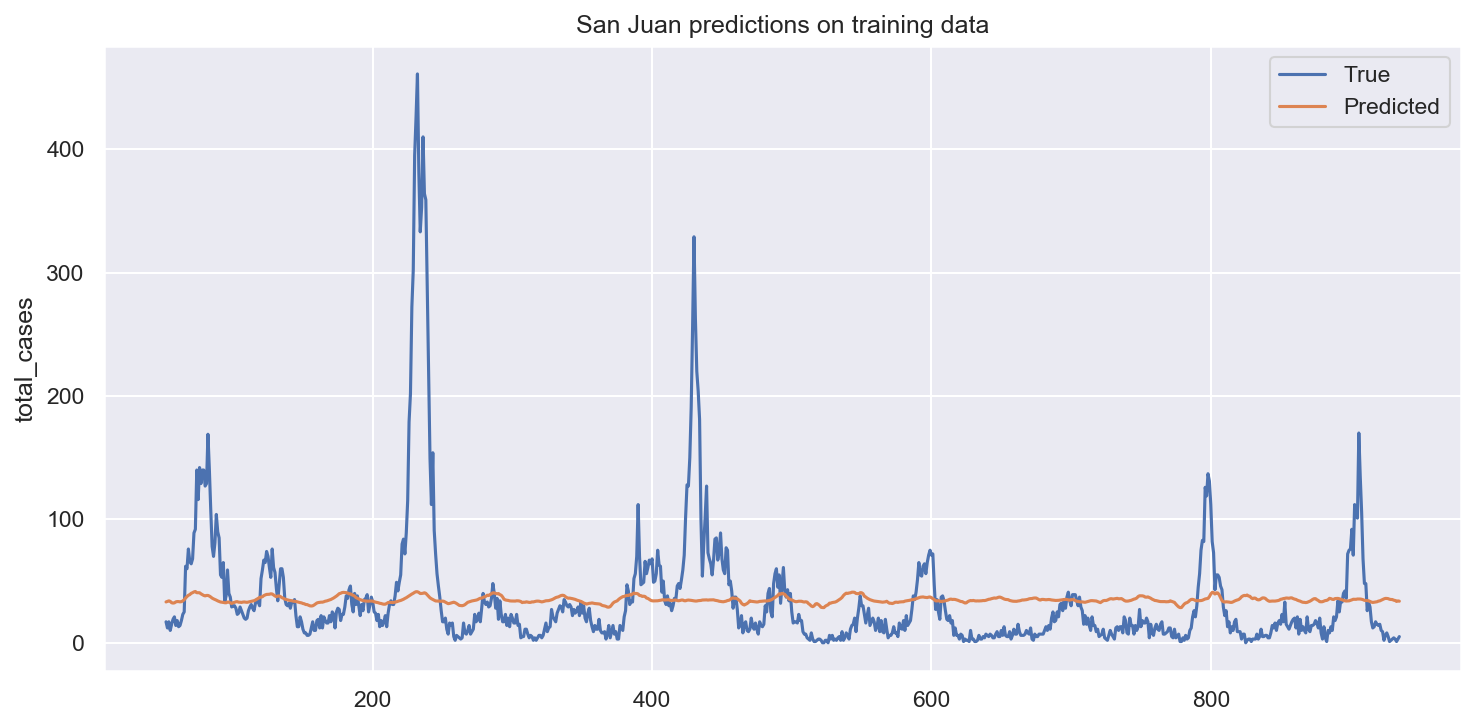

In [266]:
model_sj.fit(train_features_sj, train_labels_sj)
y_val_sj = model_sj.predict(train_features_sj).flatten()

fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = train_labels_sj, x = train_features_sj.index.values, ax = ax)
sns.lineplot(y = y_val_sj, x = train_features_sj.index.values, ax = ax)
ax.set(title = 'San Juan predictions on training data')
ax.legend(['True', 'Predicted'])

### Gradient boosting

In [278]:
model_sj = XGBRegressor(
    max_depth = 10,
    learning_rate = 0.01,
    n_estimators = 200,
    reg_lambda = 1,
    
)
cv_res_sj = cross_validate(
    estimator = model_sj,
    X = train_features_sj,
    y = train_labels_sj,
    cv = TimeSeriesSplit(n_splits = 10),
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1
)
sj_score = np.mean(cv_res_sj['test_score'])
sj_score

-27.536122611761094

##### Visualization

[02:26:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


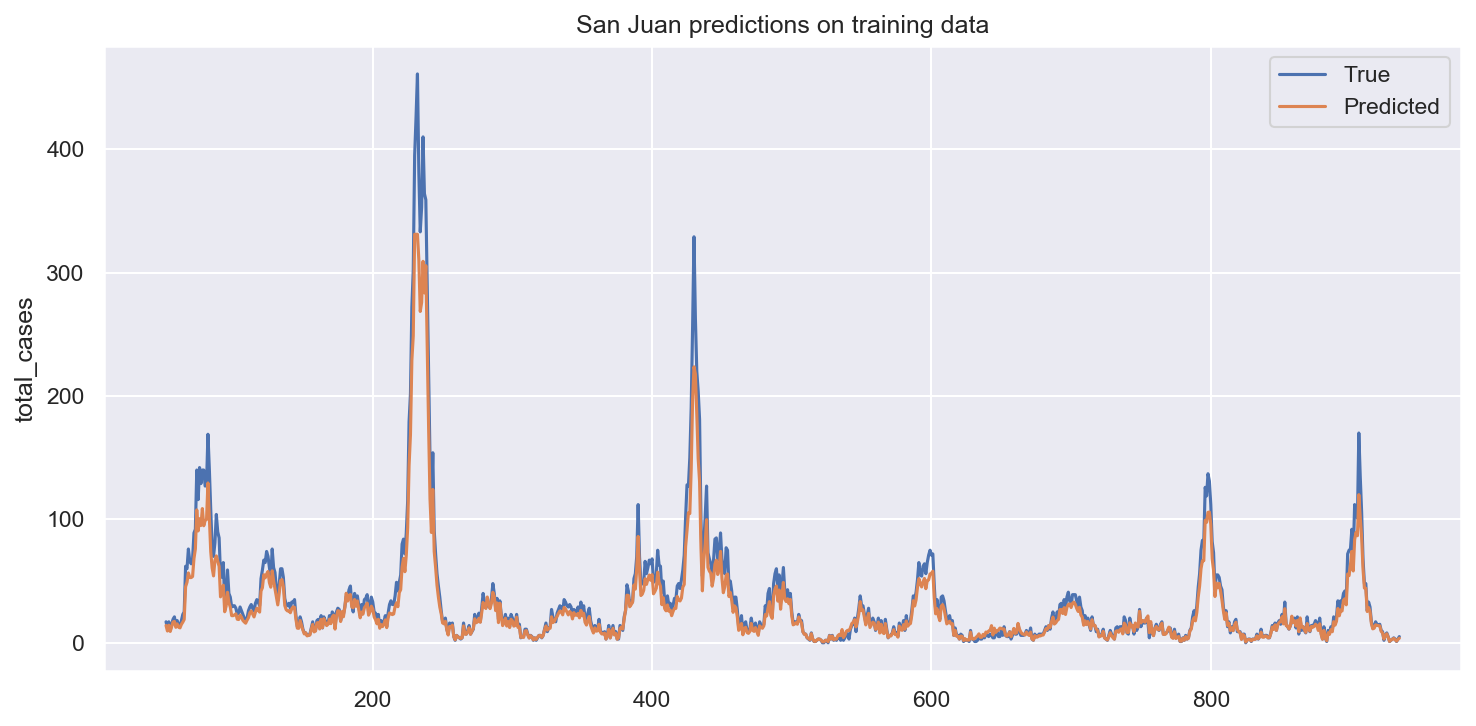

In [279]:
model_sj.fit(train_features_sj, train_labels_sj)
y_val_sj = model_sj.predict(train_features_sj).flatten()

fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = train_labels_sj, x = train_features_sj.index.values, ax = ax)
sns.lineplot(y = y_val_sj, x = train_features_sj.index.values, ax = ax)
ax.set(title = 'San Juan predictions on training data')
ax.legend(['True', 'Predicted'])

### Iquitos

#### Linear model

In [120]:
model_iq = Pipeline([
    ('scale', StandardScaler()),
    ('lasso', Lasso(2))
])

In [121]:
cv_res_iq = cross_validate(
    estimator = model_iq,
    X = train_features_iq,
    y = train_labels_iq,
    cv = TimeSeriesSplit(n_splits = 10),
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1
)
iq_score = np.mean(cv_res_iq['test_score'])
iq_score

-7.058335826276038

##### Visualization

In [122]:
model_iq.fit(train_features_iq, train_labels_iq)
y_val_iq = model_iq.predict(train_features_iq).flatten()

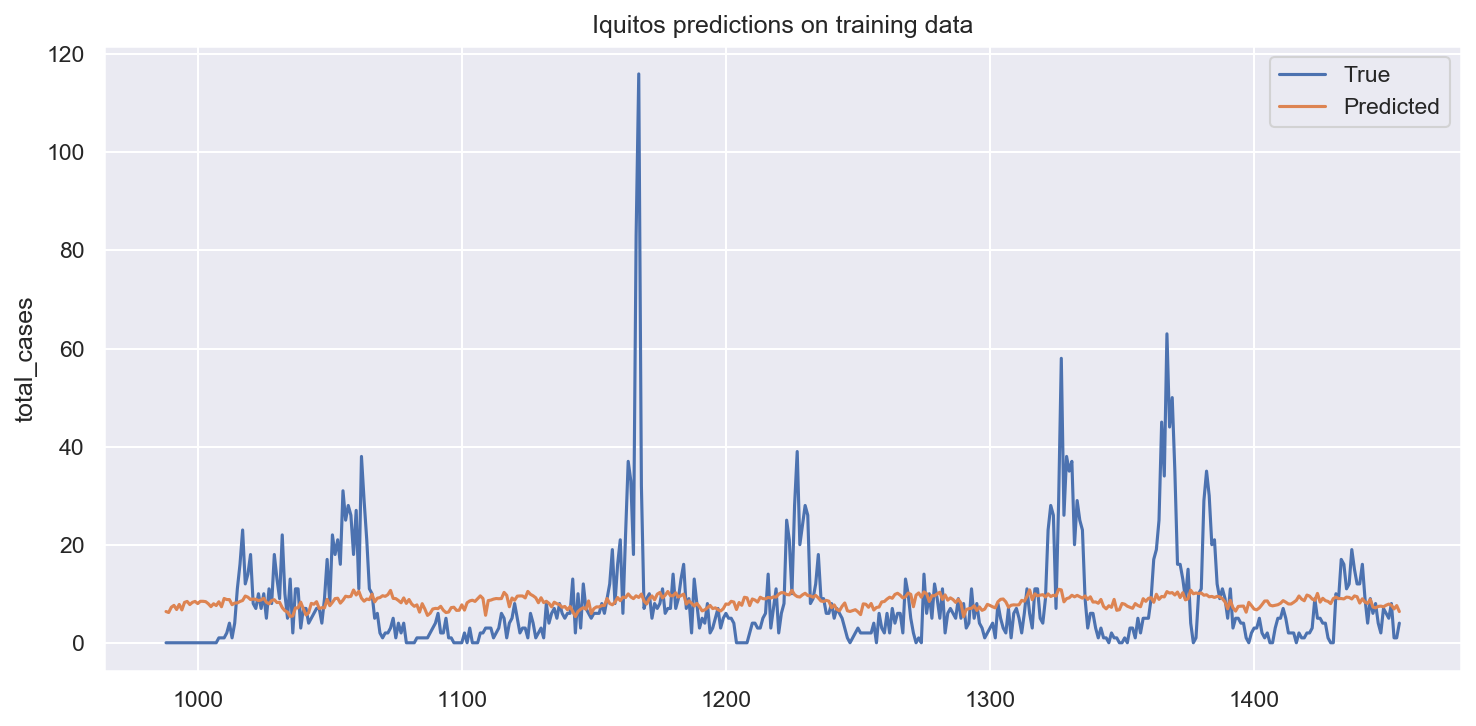

In [124]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = train_labels_iq, x = train_features_iq.index.values, ax = ax)
sns.lineplot(y = y_val_iq, x = train_features_iq.index.values, ax = ax)
ax.set(title = 'Iquitos predictions on training data')
ax.legend(['True', 'Predicted'])

### Gradient boosting

In [289]:
model_iq = XGBRegressor(
    max_depth = 10,
    learning_rate = 0.02,
    n_estimators = 200,
    reg_lambda = 20,
    
)
cv_res_iq = cross_validate(
    estimator = model_iq,
    X = train_features_iq,
    y = train_labels_iq,
    cv = TimeSeriesSplit(n_splits = 10),
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1
)
iq_score = np.mean(cv_res_iq['test_score'])
iq_score

-6.951732022705532

##### Visualization

[02:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


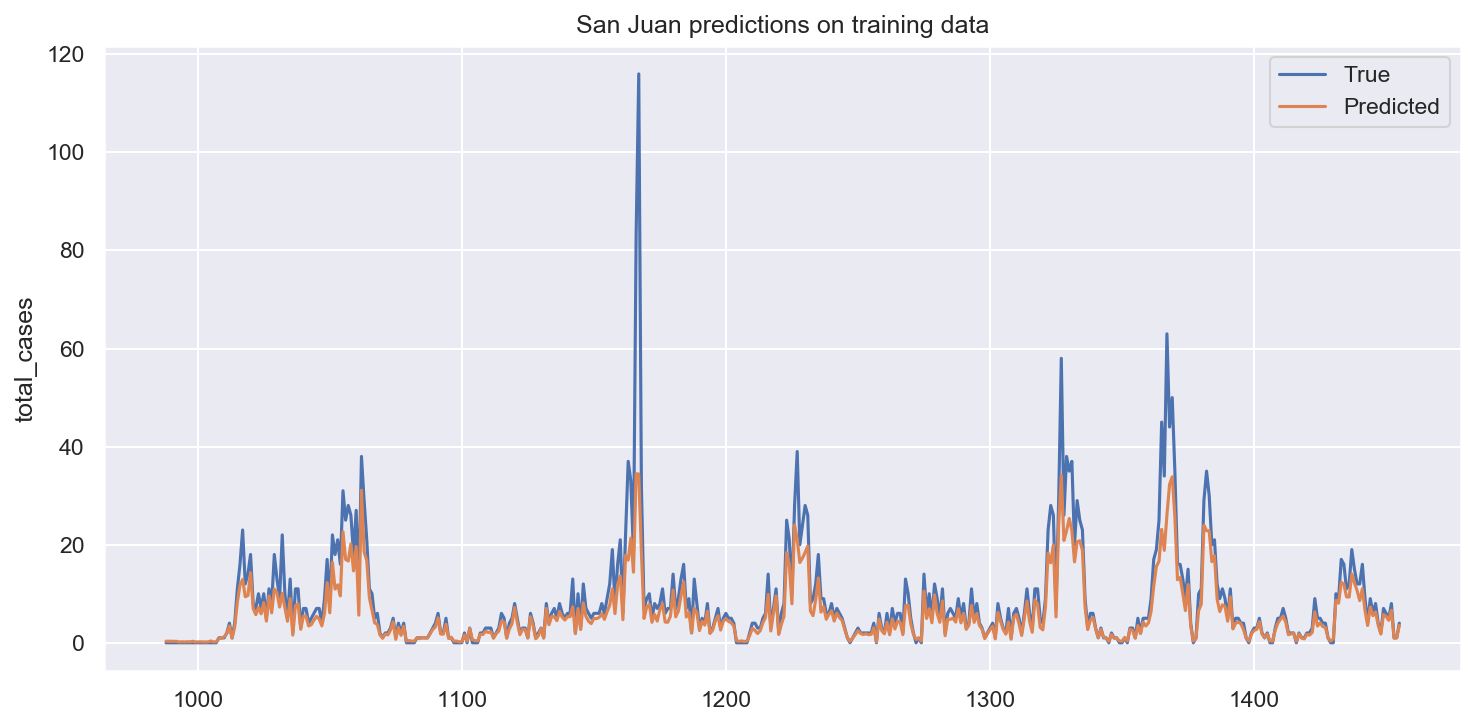

In [285]:
model_iq.fit(train_features_iq, train_labels_iq)
y_val_iq = model_iq.predict(train_features_iq).flatten()

fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = train_labels_iq, x = train_features_iq.index.values, ax = ax)
sns.lineplot(y = y_val_iq, x = train_features_iq.index.values, ax = ax)
ax.set(title = 'San Juan predictions on training data')
ax.legend(['True', 'Predicted'])

In [286]:
from sklearn.metrics import mean_absolute_error

## Overall performance

In [283]:
sj_ratio = len(train_features_sj) / (len(train_features_sj) + len(train_features_iq))
iq_ratio = len(train_features_iq) / (len(train_features_sj) + len(train_features_iq))

In [284]:
sj_ratio * sj_score + iq_ratio * iq_score

-20.420933080837948